# Turing Target Practice

## Model

In [5]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [6]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [7]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [8]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [9]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [10]:
target = TuringTarget(stat_model);

In [11]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=1_000,  
                       file_name="Turing_sequential_samples",
                       dialog=true);

Initial Virial loss: 1435.5857357359166
Virial loss: 

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳


69.2934437573563 --> Relative improvement: 0.9517315879975398
Using eps tuning method AdaptiveStep


┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/Glamdring/MicroCanonicalHMC.jl/src/tuning.jl:259


eps: 0.07 --> VarE/d: 5378.053254004172
eps: 0.02429994322745527 --> VarE/d: 563.3543686758622
eps: 0.00948262617418499 --> VarE/d: 81.0436237647363
eps: 0.004623205798855663 --> VarE/d: 18.746592217577817
eps: 0.0027591256555537617 --> VarE/d: 6.6361219009919985
eps: 0.0019016142545855994 --> VarE/d: 3.1340875737903504
eps: 0.001441801787217334 --> VarE/d: 1.7703048037983562
eps: 0.0011651106743466467 --> VarE/d: 1.1484858234407982
eps: 0.0009834766396060258 --> VarE/d: 0.8267489722804439
eps: 0.0008559568105896975 --> VarE/d: 0.6100556690023137
eps: 0.0007622705444837171 --> VarE/d: 0.47675578090044335
eps: 0.0006906323562258169 --> VarE/d: 0.3974823541532196
eps: 0.0006338336288517612 --> VarE/d: 0.3323743146615382
eps: 0.0005878280820617108 --> VarE/d: 0.2740512475517455
eps: 0.0005500677850479607 --> VarE/d: 0.22968936665258657
eps: 0.0005185743308321751 --> VarE/d: 0.22035596491982917
eps: 0.0004911366731544566 --> VarE/d: 0.20138637470623763
eps: 0.00046725826609176924 --> VarE/

[ Info: Found L: 0.031452866757971314 ✅
[ Info: Final nu 0.07318368126667191


In [12]:
std(samples_mchmc)[1:end-2]

2-element Vector{Float64}:
 0.029536833652693665
 0.0913733594915083

In [13]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

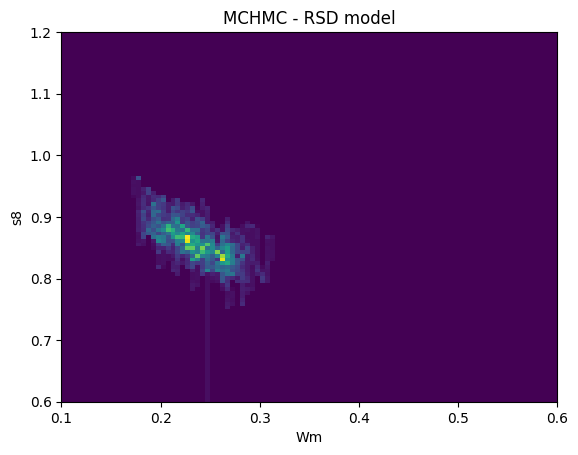

In [14]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [15]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Initial nu 0.4019513728906998
[ Info: Starting burn in ⏳


Initial Virial loss: 43476.543102433374
Virial loss: 167.3134287200322 --> Relative improvement: 0.9961516390959182
Virial loss: 131.88171589054505 --> Relative improvement: 0.21176849402073694
Virial loss: 99.27701417381904 --> Relative improvement: 0.24722685397713673
Virial loss: 87.8891322933008 --> Relative improvement: 0.11470814241632787
Virial loss: 60.86018990660033 --> Relative improvement: 0.30753452311373775
Virial loss: 42.38491308341306 --> Relative improvement: 0.30356916157410174
Virial loss: 28.563737197921213 --> Relative improvement: 0.3260871588504126
Virial loss: 28.075013699598102 --> Relative improvement: 0.017109928401059515
Virial loss: 28.007738290746268 --> Relative improvement: 0.002396273411357175


[ Info: Virial loss condition met during burn-in at step: 452
[ Info: Found sigma: [0.9973211503956849, 0.07314726907703215] ✅


Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 2.70643656725597
eps: 0.04269348051965533 --> VarE/d: 1.2993666826157468
eps: 0.03450145854089849 --> VarE/d: 0.9199403875439145
eps: 0.03034855026106582 --> VarE/d: 0.6918106098476551
eps: 0.027833002694889135 --> VarE/d: 0.6115047879338714
eps: 0.026049269795401647 --> VarE/d: 0.5253209342354013
eps: 0.024736331590483735 --> VarE/d: 0.47453436470918825
eps: 0.023708132250548755 --> VarE/d: 0.43904026264890506
eps: 0.022870406036840416 --> VarE/d: 0.4108310366933172
eps: 0.02216965562769517 --> VarE/d: 0.3908964745351507
eps: 0.02156792014273807 --> VarE/d: 0.3563624185186501
eps: 0.021061080761079855 --> VarE/d: 0.34147815459714304
eps: 0.020614225203073527 --> VarE/d: 0.3242946056551398
eps: 0.020219984875061135 --> VarE/d: 0.3309144365257297
eps: 0.019848729299711893 --> VarE/d: 0.30722538123859156
eps: 0.0195232977913818 --> VarE/d: 0.3143472524445886
eps: 0.019212103723680683 --> VarE/d: 0.29719313207692055
eps: 0.0189327

[ Info: Final nu 0.16105927319343674


In [16]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

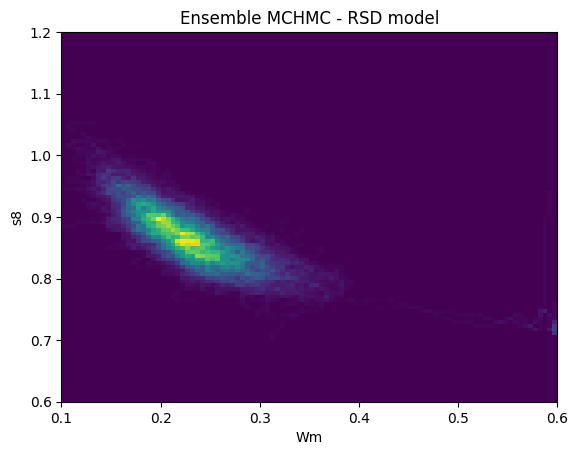

In [17]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [22]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples = sample(
    stat_model, spl, 10_000; burn_in=1_000,
    dialog=true)

Initial Virial loss: 119764.79901923773
Virial loss: 270.7876278871393 --> Relative improvement: 0.9977390048653307
Virial loss: 202.43905699621448 --> Relative improvement: 0.2524065498273489
Virial loss: 140.9162018694338 --> Relative improvement: 0.3039080305927879
Virial loss: 86.11495288865214 --> Relative improvement: 0.38889246412955314
Virial loss: 37.93581402509588 --> Relative improvement: 0.5594747166134153
Virial loss: 3.7163049199027176 --> Relative improvement: 0.9020370324083661
Virial loss: 2.7395281645286707 --> Relative improvement: 0.26283547136912977
Virial loss: 1.4269944178038194 --> Relative improvement: 0.47910941881142133
Virial loss: 1.0209039553948127 --> Relative improvement: 0.28457747090138596
Virial loss: 0.17851095230892877 --> Relative improvement: 0.825144225011947
Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 0.07470979901362391
eps: 0.05163733902098179 --> VarE/d: 0.057242233812625214
eps: 0.04478935433714323 --> VarE/d: 0.07615870881485

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 72
[ Info: Found eps: 0.02139572155675748 ✅
[ Info: Found L: 0.12256133205577889 ✅
[ Info: Final nu 0.4570842739472197
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.49 seconds
Compute duration  = 0.49 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2264    0.0447     0.0004    0.0033   142.1119    1.0485     ⋯
          σ8    0.8691    0.0434     0.0004    0.0025   260.5401    1.0299     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1527    0.1955    0.2200    0.2516    0.3353
          σ8    0.7870    0.8397    0.8679    0.8972    0.9575


In [23]:
new_samples = sample(stat_model, spl, 10000; burn_in=1_000,
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.47 seconds
Compute duration  = 0.47 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          Ωm    0.2333    0.0452     0.0005    0.0034   140.0317    1.0074     ⋯
          σ8    0.8633    0.0425     0.0004    0.0024   281.3658    1.0021     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1595    0.2014    0.2280    0.2590    0.3403
          σ8    0.7840    0.8332    0.8625    0.8912    0.9490


## Ensemble AbstractMCMC

In [26]:
spl = MCHMC(0.0, 0.0, 10; init_eps=0.07, varE_wanted=0.1)
samples = sample(stat_model, spl, 1000; burn_in=1_000)

LoadError: MethodError: no method matching step(::Random.TaskLocalRNG, ::DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}, ::MicroCanonicalHMC.EnsembleSampler; burn_in::Int64)

[0mClosest candidates are:
[0m  step(::Random.AbstractRNG, ::AbstractMCMC.AbstractModel, [91m::AdvancedPS.PG[39m)[91m got unsupported keyword argument "burn_in"[39m
[0m[90m   @[39m [36mAdvancedPS[39m [90m~/.julia/packages/AdvancedPS/Vox9w/src/[39m[90m[4msmc.jl:88[24m[39m
[0m  step(::Random.AbstractRNG, ::AbstractMCMC.AbstractModel, [91m::AdvancedPS.PG[39m, [91m::Union{Nothing, AdvancedPS.PGState}[39m; kwargs...)
[0m[90m   @[39m [36mAdvancedPS[39m [90m~/.julia/packages/AdvancedPS/Vox9w/src/[39m[90m[4msmc.jl:88[24m[39m
[0m  step(::Random.AbstractRNG, ::AbstractMCMC.AbstractModel, [91m::EllipticalSliceSampling.ESS[39m; init_params, kwargs...)
[0m[90m   @[39m [32mEllipticalSliceSampling[39m [90m~/.julia/packages/EllipticalSliceSampling/1R0Nc/src/[39m[90m[4mabstractmcmc.jl:21[24m[39m
[0m  ...


In [4]:
new_samples = sample(stat_model, 10, 1000, 100; 
                     resume_from=samples)

LoadError: UndefVarError: `MCHMC` not defined

## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

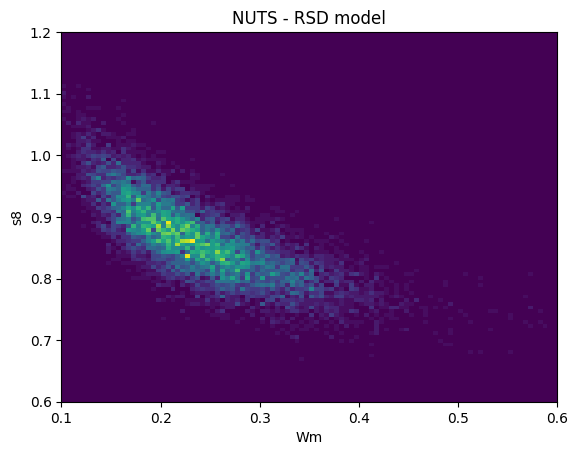

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");